# Лабораторная работа №3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from math import sqrt
import sys

## Постановка задачи
Для 5 распределений:
* Нормальное распределение $N(x,0,1)$;
* Распределение Коши $C(x,0,1)$;
* Распределение Лапласа $L(x,0,\frac{1}{\sqrt{2}})$;
* Распределение Пуассона $P(k,10)$;
* Равномерное распределение $U(x,-\sqrt{3},\sqrt{3})$

Сгенерировать выборки размером 20 и 100 элементов. Построить для них боксплот Тьюки.\
Для каждого распределения определить долю выбросов экспериментально (сгенерировав выборку, соответствующую распределению 1000 раз, и вычислив среднюю долю выбросов) и сравнить с результатами, полученными теоретически.

## Теория
### Определение
Боксплот (англ. box plot) — график, использующийся в описательной статистике, компактно изображающий одномерное распределение вероятностей.
### Описание
Такой вид диаграммы в удобной форме показывает медиану, нижний и верхний квартили и выбросы. Несколько таких ящиков можно нарисовать бок о бок, чтобы визуально сравнивать одно распределение с другим; их можно располагать как горизонтально, так и вертикально. Расстояния между различными частями ящика позволяют определить степень разброса (дисперсии) и асимметрии данных и выявить выбросы.
### Построение
Границами ящика служат первый и третий квартили, линия в середине ящика — медиана. Концы усов — края статистически значимой выборки (без выбросов). Длину «усов» определяют разность первого квартиля и полутора межквартильных расстояний и сумма третьего квартиля и полутора межквартильных расстояний. Формула имеет вид:
$$X_1=Q_1-{3\over{2}}(Q_3-Q_1), X_2=Q_3+{3\over{2}}(Q_3-Q_1)$$
где $X_1$ — нижняя граница уса, $X_2$ — верхняя граница уса, $Q_1$ — первый квартиль, $Q_3$ — третий квартиль. Данные, выходящие за границы усов (выбросы), отображаются на графике в виде маленьких кружков.

## Реализация

In [2]:
# Normal distribution
normal_distribution = {
    'distrib' : np.random.standard_normal,
    'pdf' : stats.norm.pdf,
    'cdf' : stats.norm.cdf,
    'ppf' : stats.norm.ppf,
    'title' : "Normal distribution $N(x,0,1)$",
    'name' : "Normal distribution",
}

# Cauchy distribution
cauchy_distribution = {
    'distrib' : np.random.standard_cauchy,
    'pdf' : stats.cauchy.pdf,
    'cdf' : stats.cauchy.cdf,
    'ppf' : stats.cauchy.ppf,
    'title' : "Cauchy distribution $C(x,0,1)$",
    'name' : "Cauchy distribution",
}

# Laplace distribution
laplace_param = [0, 1 / sqrt(2)] # mu, lambda
laplace_distribution = {
    'distrib' : lambda n: np.random.laplace(laplace_param[0], laplace_param[1], n),
    'pdf' : lambda x: stats.laplace.pdf(x, laplace_param[0], laplace_param[1]),
    'cdf' : lambda x: stats.laplace.cdf(x, laplace_param[0], laplace_param[1]),
    'ppf' : lambda q: stats.laplace.ppf(q, laplace_param[0], laplace_param[1]),
    'title' : "Laplace distribution $L(x,0,1 / \sqrt{2})$",
    'name' : "Laplace distribution",
}

# Poisson distribution
poisson_param = 10 # mu
poisson_distribution = {
    'distrib' : lambda n: np.random.poisson(poisson_param, n),
    'pdf' : lambda x: (np.power(x, poisson_param) / np.math.factorial(poisson_param)) * np.exp(-x),
    'pmf' : lambda k: stats.poisson.pmf(k, poisson_param),
    'cdf' : lambda k: stats.poisson.cdf(k, poisson_param),
    'ppf' : lambda q: stats.poisson.ppf(q, poisson_param),
    'title' : "Poisson distribution $P(k,10)$",
    'name' : "Poisson distribution",
}

# Uniform distribution
segment = [-sqrt(3), sqrt(3)]
uniform_distribution = {
    'distrib' : lambda n: np.random.uniform(segment[0], segment[1], n),
    'pdf' : lambda x: stats.uniform.pdf(x, segment[0], segment[1] - segment[0]),
    'cdf' : lambda x: stats.uniform.cdf(x, segment[0], segment[1] - segment[0]),
    'ppf' : lambda q: stats.uniform.ppf(q, segment[0], segment[1] - segment[0]),
    'title' : "Uniform distribution $U(x,-\sqrt{3},\sqrt{3})$",
    'name' : "Uniform distribution",
}

In [12]:
def TheoreticalProbabilityOfOutliers(distribution, rounded=4):
    Q_1 = distribution['ppf'](0.25)
    Q_3 = distribution['ppf'](0.75)
    bottom = Q_1 - 1.5 * (Q_3 - Q_1)
    top = Q_3 + 1.5 * (Q_3 - Q_1)
    if distribution['name'] == "Poisson distribution":
        P = (distribution['cdf'](bottom) - distribution['pmf'](bottom)) + (1 - distribution['cdf'](top)) 
    else:
        P = distribution['cdf'](bottom) + (1 - distribution['cdf'](top)) 
    return np.round([Q_1, Q_3, bottom, top, P], rounded)

def NumOutliers(x):
    x.sort()
    num_outliers = 0
    Q_1 = np.quantile(x, 0.25)
    Q_3 = np.quantile(x, 0.75)
    bottom = Q_1 - 1.5 * (Q_3 - Q_1)
    top = Q_3 + 1.5 * (Q_3 - Q_1)
    for elem in x:
        if elem < bottom or elem > top:
            num_outliers += 1
    return num_outliers / x.size

def ResearchDistibution(distribution, n, iter_num, rounded=4):
    np.random.seed(42)
    
    data = []
    for i in range(len(n)):
        x = distribution['distrib'](n[i])
        data.append(x)
        
    res = []
    for i in range(len(n)):
        z = []
        for _ in range(iter_num):
            x = distribution['distrib'](n[i])
            z.append(NumOutliers(x))
        res.append(round(np.mean(z), rounded))
    
    plt.figure(distribution['name'])
    # plt.title(distribution['title'])
    plt.xlabel("x")
    plt.ylabel("n")
    plt.boxplot(data, labels=n, vert=False)
    plt.savefig("pictures/"+distribution['name'])
    plt.show()
    
    return res

In [13]:
n = [20, 100]
iter_num = 1000

distributions = [normal_distribution,
                 cauchy_distribution,
                 laplace_distribution,
                 poisson_distribution,
                 uniform_distribution]

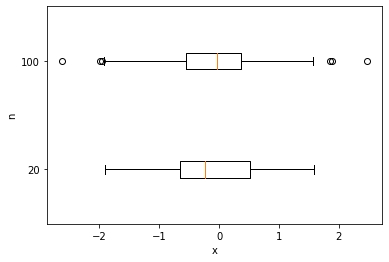

percentage_outliers: [0.0239, 0.0101]


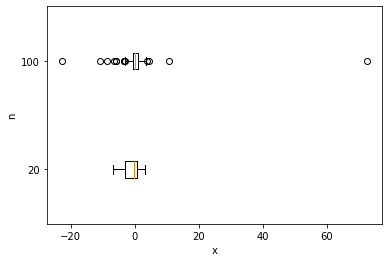

percentage_outliers: [0.1516, 0.1544]


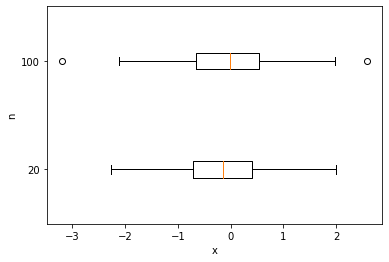

percentage_outliers: [0.0739, 0.0632]


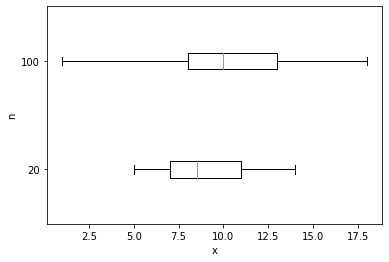

percentage_outliers: [0.0242, 0.0105]


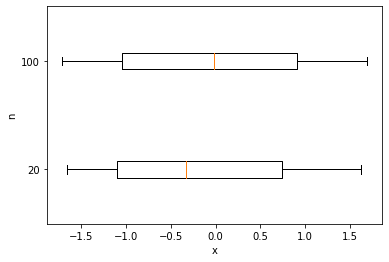

percentage_outliers: [0.002, 0.0]


In [14]:
file = open('outliers/percentage_outliers.txt', 'w')
for distrib in distributions:
    tmp = ResearchDistibution(distrib, n, iter_num)
    print("percentage_outliers:", tmp)
    file.write("%s:\n%s\n" %(distrib['name'], str(tmp)))
file.close()

In [19]:
file = open('outliers/theoretical_outliers.txt', 'w')
for distrib in distributions:
    tmp = TheoreticalProbabilityOfOutliers(distrib)
    print(distrib['name'] + ":")
    print("theoretical_outliers:", tmp)
    file.write("%s:\n%s\n" %(distrib['name'], str(tmp)))
file.close()

Normal distribution:
theoretical_outliers: [-0.6745  0.6745 -2.698   2.698   0.007 ]
Cauchy distribution:
theoretical_outliers: [-1.     1.    -4.     4.     0.156]
Laplace distribution:
theoretical_outliers: [-0.4901  0.4901 -1.9605  1.9605  0.0625]
Poisson distribution:
theoretical_outliers: [8.0e+00 1.2e+01 2.0e+00 1.8e+01 7.7e-03]
Uniform distribution:
theoretical_outliers: [-0.866   0.866  -3.4641  3.4641  0.    ]
